# Analysis of Bike Trips
This notebook explores bike trips data, visualizes heatmaps, and uncovers weekly and hourly patterns.

In [ ]:
# Requirements for this analysis
!pip install pandas numpy matplotlib folium
# !pip3 install pandas numpy matplotlib folium

In [2]:
# Core for Data Analysis
import pandas as pd
import ast
import numpy as np

# Visualization and Mapping
import matplotlib.pyplot as plt
from folium import Map, Rectangle
from folium.plugins import HeatMap, HeatMapWithTime

### Load & Inspect Dataset
We load the dataset and check for missing values.
Since the file format is not a standard CSV — it mixes CSV structure with embedded Python-like dictionaries — pandas.read_csv() fails to parse it correctly.

Therefore, we perform the following steps:

1. Read the CSV file line-by-line.
2. Extract the dictionary-like string after the first comma.
3. Parse the string into a Python dictionary.
4. Collect all dictionaries into a list, and convert it into DataFrame.

In [3]:
# Read the file line-by-line
with open("bike_data.csv", "r") as f:
    lines = f.readlines()[1:]  # skip header

# Extract the part after the comma and parse as dictionary
records = []
for line in lines:
    try:
        raw_dict = line.split(",", 1)[1].strip().strip('"')
        parsed_dict = ast.literal_eval(raw_dict)
        records.append(parsed_dict)
    except Exception as e:
        print(f"Skipping line due to error: {e}")

# Convert list of dicts to DataFrame
df = pd.DataFrame(records) 
print(f'Number of null values: {df.isna().sum().sum()}')
df.head()

Number of null values: 0


,trip_id,end_time,coordinates,vehicle_type,accuracy,trip_distance,propulsion_types,SID,start_time,timestamps_list,trip_duration,vehicle_id,timestamp,_headers
0,439f9229-2784-4338-9773-d652c9e568cc,1690844643510,"[[8.262563, 50.000889], [8.262563, 50.000889],...",scooter,8.0,1926.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690844227199,"[1690844227000, 1690844229000, 1690844238000, ...",416.0,403328,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'}
1,c55453e0-b755-4158-9d78-d333097ecb45,1690845074877,"[[8.227722, 49.996441], [8.22736, 49.996296], ...",scooter,8.0,2294.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690844576447,"[1690844576000, 1690844589000, 1690844597000, ...",498.0,420400,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'}
2,916c12fa-965e-4902-a92f-e4804944093b,1690847157514,"[[8.267058, 49.984197], [8.267061, 49.984202],...",scooter,8.0,3689.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690846148466,"[1690846148000, 1690846160000, 1690846171000, ...",1009.0,419482,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'}
3,62efe364-30f4-4f48-b80a-d6c193dcdf86,1690845354405,"[[8.259436, 50.005557], [8.259816, 50.0054], [...",scooter,8.0,2613.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690844783757,"[1690844783000, 1690844795000, 1690844806000, ...",571.0,415192,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'}
4,9140fcef-3652-4b25-80b9-2304c4a3b6da,1690845213966,"[[8.279259, 49.996319], [8.279267, 49.996318],...",scooter,8.0,1538.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,1690844894374,"[1690844894000, 1690844896000, 1690844906000, ...",320.0,421106,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'}


### Cleaning & Formatting
The previous inspection shown the lack of null values. Therefore we only convert timestamps to datatime format and extract the hour and weekday from the start_time for the future analysis.

In [4]:
# Convert timestamps to datetime
df['start_time'] = pd.to_datetime(df['start_time'], unit='ms')
df['hour']= df['start_time'].dt.hour
df['weekday'] = df['start_time'].dt.day_name()
df['end_time'] = pd.to_datetime(df['end_time'], unit='ms')
df['timestamps_list'] = df["timestamps_list"].apply(
    lambda x: pd.to_datetime(x, unit='ms')
)
df.head()

,trip_id,end_time,coordinates,vehicle_type,accuracy,trip_distance,propulsion_types,SID,start_time,timestamps_list,trip_duration,vehicle_id,timestamp,_headers,hour,weekday
0,439f9229-2784-4338-9773-d652c9e568cc,2023-07-31 23:04:03.510,"[[8.262563, 50.000889], [8.262563, 50.000889],...",scooter,8.0,1926.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 22:57:07.199,"DatetimeIndex(['2023-07-31 22:57:07', '2023-07...",416.0,403328,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},22,Monday
1,c55453e0-b755-4158-9d78-d333097ecb45,2023-07-31 23:11:14.877,"[[8.227722, 49.996441], [8.22736, 49.996296], ...",scooter,8.0,2294.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 23:02:56.447,"DatetimeIndex(['2023-07-31 23:02:56', '2023-07...",498.0,420400,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},23,Monday
2,916c12fa-965e-4902-a92f-e4804944093b,2023-07-31 23:45:57.514,"[[8.267058, 49.984197], [8.267061, 49.984202],...",scooter,8.0,3689.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 23:29:08.466,"DatetimeIndex(['2023-07-31 23:29:08', '2023-07...",1009.0,419482,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},23,Monday
3,62efe364-30f4-4f48-b80a-d6c193dcdf86,2023-07-31 23:15:54.405,"[[8.259436, 50.005557], [8.259816, 50.0054], [...",scooter,8.0,2613.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 23:06:23.757,"DatetimeIndex(['2023-07-31 23:06:23', '2023-07...",571.0,415192,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},23,Monday
4,9140fcef-3652-4b25-80b9-2304c4a3b6da,2023-07-31 23:13:33.966,"[[8.279259, 49.996319], [8.279267, 49.996318],...",scooter,8.0,1538.0,electric,b2dbe616-456a-4cd6-bd22-9547941dbdd5,2023-07-31 23:08:14.374,"DatetimeIndex(['2023-07-31 23:08:14', '2023-07...",320.0,421106,2023-08-01T00:45:59.936Z,{'eventType': 'MdsTierEventType'},23,Monday


### Spatial consistency
We verify that all coordinates are concentrated within the same city or its surrounding area, as we want to identify mobility patterns and generate accurate heatmaps. Including coordinates from geographically distant regions would introduce noise and lead to misleading visual clusters. In our case, all coordinates are located in and around Mainz. 


In [5]:
# Extract all coordinates into a single list
all_coords = []
for coords in df['coordinates']:
    all_coords.extend(coords)

# Convert to a NumPy array for easier calculations
all_coords = np.array(all_coords)

# Calculate min/max lat and lon
min_lon, max_lon = np.min(all_coords[:, 0]), np.max(all_coords[:, 0])
min_lat, max_lat = np.min(all_coords[:, 1]), np.max(all_coords[:, 1])
area_center = (np.mean([min_lat, max_lat]), np.mean([min_lon, max_lon]))
m = Map(location=area_center, zoom_start=10)
Rectangle(
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    color='red',
    fill=True
).add_to(m)
m

### Temporal Consistency
We verify the time intervals between sensor readings for each trip. This step is important because irregular intervals may indicate issues that affect further analysis, such as road reconstruction.

1. Calculate the time intervals between timestamps.
2. All time intervals are then concatenated into a single array and visualized using a histogram with predefined bins.
3. The histogram is displayed on a logarithmic scale to better capture the distribution across a wide range of frequencies.

In our case, 99.98% of sensor readings occurred within 10-minute intervals. This indicates a good level of temporal regularity in the data.

Bin 0–600 sec: 2797663.0 intervals (99.98%)
Bin 600–1200 sec: 285.0 intervals (0.01%)
Bin 1200–1800 sec: 84.0 intervals (0.00%)
Bin 1800–2400 sec: 46.0 intervals (0.00%)
Bin 2400–3000 sec: 18.0 intervals (0.00%)
Bin 3000–3600 sec: 5.0 intervals (0.00%)
Bin 3600–4200 sec: 1.0 intervals (0.00%)


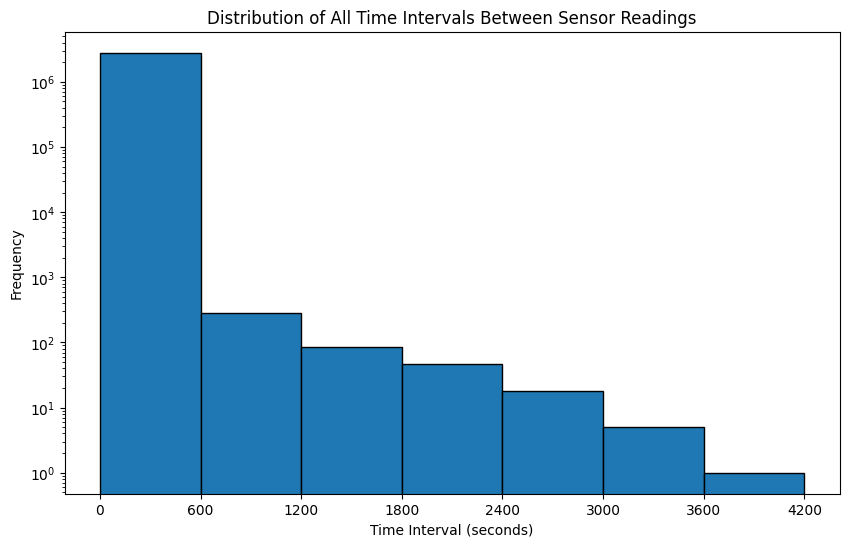

In [6]:
# Function to calculate time intervals between consecutive timestamps
def calculate_time_intervals(timestamps):
    if len(timestamps) < 2:
        return []
    # Convert to seconds
    intervals = np.diff(timestamps).astype('timedelta64[ms]').astype(int) / 1000 
    return intervals

# Apply the function to each trip
df['time_intervals'] = df['timestamps_list'].apply(calculate_time_intervals)

# Plot histogram of all intervals (flattened)
all_intervals = np.concatenate(df['time_intervals'].values)
plt.figure(figsize=(10, 6))
custom_bins=[0,600,1200,1800,2400,3000,3600,4200,]
counts, bins, _ = plt.hist(all_intervals, bins=custom_bins, edgecolor='black', density=False)
for i in range(len(counts)):
    left = int(bins[i])
    right = int(bins[i+1])
    percentage = counts[i] / np.sum(counts) * 100
    print(f"Bin {left}–{right} sec: {counts[i]} intervals ({percentage:.2f}%)")
plt.xticks(bins.astype(int))
plt.yscale('log')
plt.title('Distribution of All Time Intervals Between Sensor Readings')
plt.xlabel('Time Interval (seconds)')
plt.ylabel('Frequency')
plt.show()

### Distribution of Trips by Weekday
This line plot highlights peak mobility activity by weekday, revealing that the highest number of trips occur on Friday and the lowest around on Sunday.

Text(0.5, 1.0, 'Distribution of Trips by Weekday')

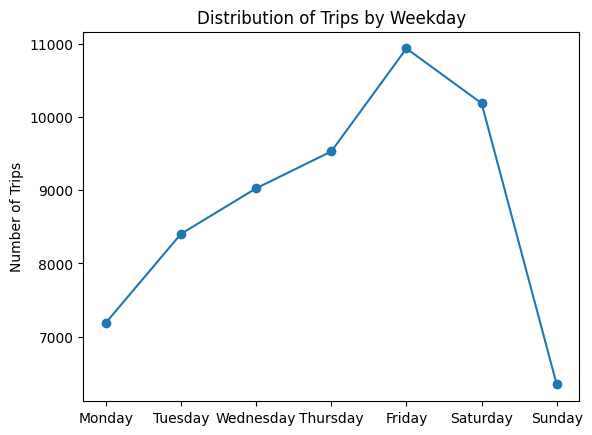

In [7]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['weekday'].value_counts().reindex(weekday_order)
weekday_counts.plot(kind='line', marker='o')
plt.xlabel('')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Weekday')

### Distribution of Trips by Hour of Day
This line plot highlights peak mobility activity by hour, revealing that the highest number of trips occur around 16:00 and the lowest around 14:00.

Text(0.5, 1.0, 'Distribution of Trips by Hour of Day')

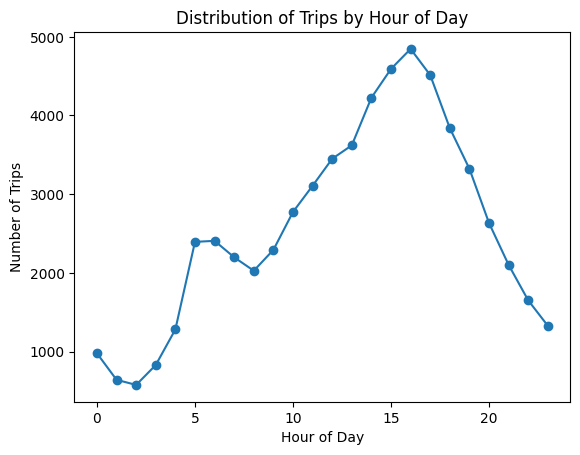

In [8]:
hourly_counts = df['hour'].value_counts().sort_index()
hourly_counts.plot(kind='line', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Hour of Day')

### Heatmap Visualization over Real City Map
To better visualize the spatial patterns of movement, we generate a heatmap overlaid on a real city map. The folium library generates heavy maps; therefore, they are not saved in the notebook, and the corresponding code cell should be executed to generate the heatmap. The generation can take up to several minutes.

1.  **Interpolation:**
    
    To ensure the heatmap accurately reflects continuous movement, we interpolate points between each pair of coordinates using linear interpolation with a fixed distance step (50 meters). Previously, we found out that all coordinates are located within a single city and its surrounding area, so we can use Euclidean distances since on such a small area, the curvature of the Earth is negligible.

2.  **Heatmap Rendering:**
    
    We use folium to visualize interpolated points into a heatmap.

It highlights that the most used roads are around **Mainz Central Station**, **Altstadt**, and **Neustadt**.

In [ ]:
def interpolate_coords(p1, p2, step_meters=50):
    p1_np = np.array(p1)
    p2_np = np.array(p2)

    dist_degrees = np.linalg.norm(p2_np - p1_np)

    estimated_total_meters = dist_degrees * 100000 
    n_steps = max(1, int(estimated_total_meters / step_meters))

    return [
        [
            p1[1] + (p2[1] - p1[1]) * i / n_steps, #lat
            p1[0] + (p2[0] - p1[0]) * i / n_steps, #lon
        ]
        for i in range(n_steps + 1)
    ]

# Initialize a list for visualization of coordinates
all_coords = []

for coords in df['coordinates']:
    if not coords or len(coords) < 2:
        continue

    for i in range(len(coords) - 1):
        inter_coords = interpolate_coords(coords[i], coords[i + 1])
        # Remove the duplicate at the segments junction 
        if i > 0:
            inter_coords = inter_coords[1:]

        all_coords.extend(inter_coords)

# Display the heatmap
m = Map(location=area_center, zoom_start=10)
HeatMap(all_coords, radius=8).add_to(m)
m

### Heatmap by Weekday
It visualizes spatial activity patterns across different days of the week. The folium library generates heavy maps; therefore, they are not saved in the notebook, and the corresponding code cells should be executed to generate the maps. The generation can take up to several minutes.

1.  **Grouping:** 

    The dataset is grouped by the "weekday" column using groupby().

2.  **Weight Normalization:**

    To avoid bias from days with more total points, we normalize weights by assigning each point a weight of 1 / total_points for that day.

3.  **Rendering:** 

    We use HeatMapWithTime from folium.plugins to display changes in route density over the week. 


In [ ]:
# Group the dataset by weekday
grouped = df.groupby("weekday")

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Initialize a matrix for visualization
# Each row contains data for a specific weekday
heatmap_data = []

# Fill the matrix with data for each weekday
for day in weekday_order:
    raw_coords = []
    for coords in grouped.get_group(day)["coordinates"]:
        if not coords or len(coords) < 2:
            continue

        for i in range(len(coords) - 1):
            inter_coords = interpolate_coords(coords[i], coords[i + 1])
            # Remove the duplicate at the segment junction
            if i > 0:
                inter_coords = inter_coords[1:]

            raw_coords.extend(inter_coords)

    # Assign weight to each point
    if raw_coords:
        weight = 1 / len(raw_coords)
        day_coords = [[lat, lon, weight] for lat, lon in raw_coords]
    else:
        day_coords = []

    heatmap_data.append(day_coords)

# Display the animated heatmap by weekday
m = Map(location=area_center, zoom_start=13)
HeatMapWithTime(
    data=heatmap_data,
    index=weekday_order,
    radius=8,
    max_opacity=0.6,
).add_to(m)

m

### Heatmap by Hour of Day
It visualizes spatial activity patterns across different hours of the day. It has the same implementation as the heatmap by weekday.

In [ ]:
# Group the dataset by hour of the day
grouped = df.groupby("hour")

hour_labels = [f"{h:02d}:00" for h in range(24)]

# Initialize a matrix for visualization
# Each row contains data for a specific hour of the day
heatmap_data = []

# Fill the matrix with data for each hour of the day
for hour in range(24):
    raw_coords = []
    for coords in grouped.get_group(hour)["coordinates"]:
        if not coords or len(coords) < 2:
            continue

        for i in range(len(coords) - 1):
            inter_coords = interpolate_coords(coords[i], coords[i + 1])
            # Remove the duplicate at the segments junction 
            if i > 0:
                inter_coords = inter_coords[1:]

            raw_coords.extend(inter_coords)
    
    # Add weight to each point
    if raw_coords:
        weight = 1 / len(raw_coords)
        hour_coords = [[lat,lon, weight] for lat, lon in raw_coords]
    else:
        hour_coords = []
    heatmap_data.append(hour_coords)

# Display the animated heatmap by hour of the day
m = Map(location=area_center, zoom_start=13)
HeatMapWithTime(
    data=heatmap_data,
    index=hour_labels,
    radius=8,
    max_opacity=0.6
).add_to(m)

m

## Results

### Distribution of Trips by Weekday
    
- Friday and Saturday are the peak days.
- Sunday and Monday show the lowest activity.

### Distribution of Trips by Hour of Day
    
- The number of trips grows from 8:00 and peaks at 16:00.
- The lowest activity was indicated at 2:00.

### Heatmap Visualization over Real City Map
    
- High-traffic zones are around the Mainz Central Station, in Altstadt and Neustadt.

### Heatmap by Weekday
    
- Friday and Saturday show the highest concentrations of trips.
- Monday and Sunday are the least active.
- Regardless of the day of the week, the Mainz Central Station, Altstadt, and Neustadt are the busiest areas.

### Heatmap by Hour of Day
    
- The growth of activity from 8:00 to 16:00 is clearly visible, as well as the decline after 16:00 to 3:00.
- Regardless of the hour of the day, The Mainz Central Station and Altstadt are the busiest areas.
